### Import pandas and read in the csv file and set it to a dataframe called baskets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections


 -  make a function for preparing data, that
    - read in data from a filename
    - clean data: remove rows with NA's, convert "id" columns into categorical type
    - make columns for date, year, month, day, hour, weekday, from the "placed_at" column

 - make a function that construct a new data frame for "merchants" from the basket data, that
   - compute the total number of spending, number of orders, number of days, number of SKU's, number of top categories, number of sub categories
   - total spent = sum of (quantity times price) 
   - average spent per order = total spent divided by number of orders

In [3]:
from math import floor


def clean_data(baskets):
    baskets.dropna(inplace=True)
    for s in baskets.columns:
        if ("id" in s):
            baskets.loc[:,s] = pd.Categorical(baskets.loc[:,s].apply(lambda x: floor(x)))
    return baskets

def convert_date(baskets):
    baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))
    baskets['date'] = baskets['datetime'].dt.date
    baskets['year'] = baskets['datetime'].dt.year
    baskets['month'] = baskets['datetime'].dt.month
    baskets['day'] = baskets['datetime'].dt.day
    baskets['hour'] = baskets['datetime'].dt.hour
    baskets['weekday'] = baskets['datetime'].dt.weekday
    return(baskets)

def prep_data(filename):
    baskets = pd.read_csv(filename)
    baskets = clean_data(baskets)
    baskets = convert_date(baskets)
    baskets["spent"] = baskets["qty"] * baskets["price"]
    return baskets

def make_merchants(baskets):
    merchants = baskets.groupby(['merchant_id'])\
        .agg({'spent': 'sum', 
                'order_id': 'nunique', 
                'date': 'nunique', 
                'sku_id':'nunique', 
                'top_cat_id':'nunique', 
                'sub_cat_id':'nunique'})\
        .reset_index()\
        .rename(columns={'spent':'total_spent', 'order_id':'num_orders', 'date':'num_days', 'sku_id':'num_skus', 'top_cat_id':'num_top_cats', 'sub_cat_id':'num_sub_cats'})
    merchants['avg_spent_per_order'] = merchants.total_spent / merchants.num_orders
    return merchants

def make_skus(baskets):
    skus_by_day = baskets.groupby(['sku_id','date'])\
        .agg({'price': 'mean',
            'order_id': 'nunique', 
            'merchant_id': 'nunique'})\
        .reset_index()\
        .rename(columns={'price':'avg_price_by_day', 'order_id':'num_orders_by_day', 'merchant_id':'num_merchants_by_day'})
    return skus_by_day

def make_top_cats(baskets):
    top_cats = baskets.groupby(['top_cat_id'])\
        .agg({'price': 'mean',
            'spent': 'sum',
            'qty' : 'sum',
            'order_id': 'nunique', 
            'date' : 'nunique',
            'merchant_id': 'nunique'})\
        .reset_index()\
        .rename(columns={'price':'avg_price', 'spent':'total_spent', 'qty':'total_quantity','order_id':'num_orders', 'merchant_id':'num_merchants'})
    return top_cats


In [4]:
filename = 'new_baskets_full.csv'
baskets = prep_data(filename)
merchants = make_merchants(baskets)
skus = make_skus(baskets)
top_cats = make_top_cats(baskets)

In [5]:
top_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   top_cat_id      33 non-null     category
 1   avg_price       33 non-null     float64 
 2   total_spent     33 non-null     float64 
 3   total_quantity  33 non-null     int64   
 4   num_orders      33 non-null     int64   
 5   date            33 non-null     int64   
 6   num_merchants   33 non-null     int64   
dtypes: category(1), float64(2), int64(4)
memory usage: 3.0 KB


In [6]:
filename10 = 'baskets_sample_random_10.csv'
baskets10 = prep_data(filename10)
merchants10 = make_merchants(baskets10)
skus10 = make_skus(baskets10)

filename250 = 'new_baskets_sample_top_250.csv'
baskets250 = prep_data(filename250)
merchants250 = make_merchants(baskets250)
skus250 = make_skus(baskets250)


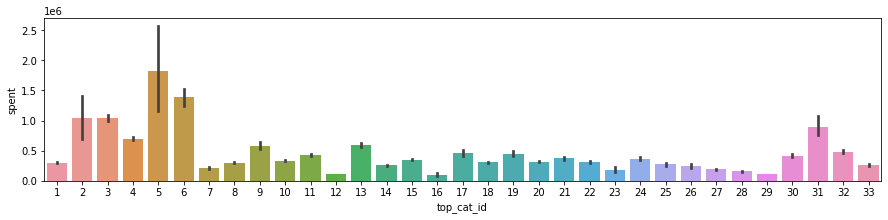

In [101]:
plt.figure(figsize=(15,3)) 
ax = sns.barplot(x="top_cat_id", y="spent", data=baskets)


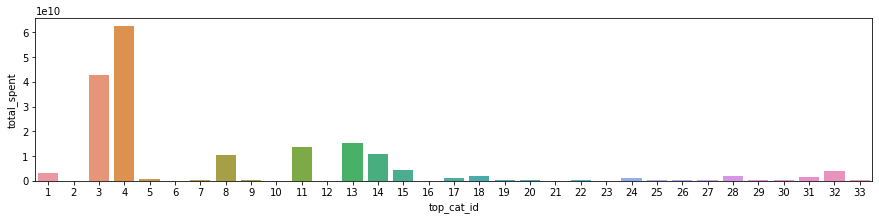

In [7]:
plt.figure(figsize=(15,3)) 
ax = sns.barplot(x="top_cat_id", y="total_spent", data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='total_quantity'>

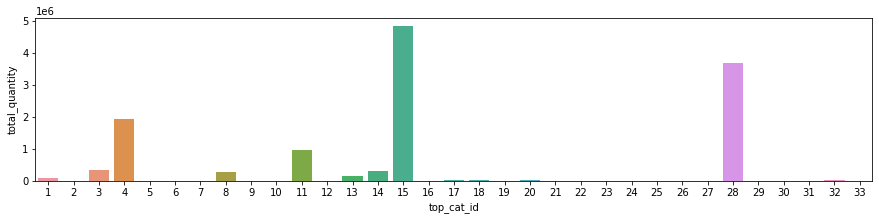

In [8]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='total_quantity',data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='num_orders'>

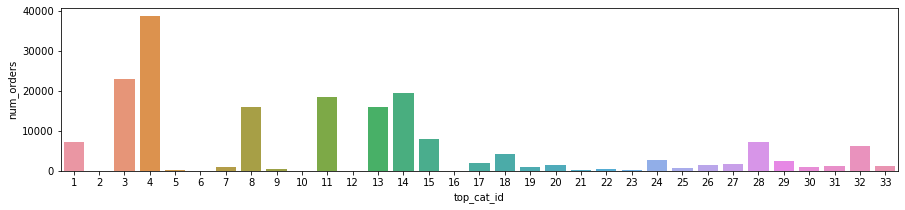

In [9]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='num_orders',data=top_cats)

<AxesSubplot:xlabel='top_cat_id', ylabel='avg_price'>

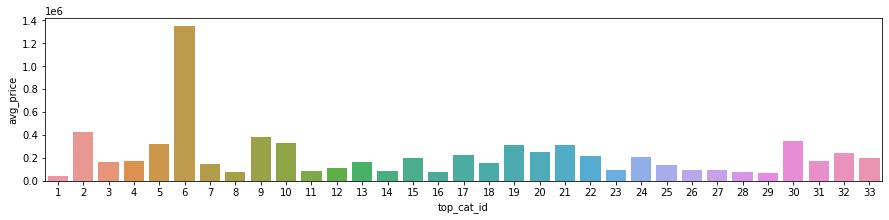

In [10]:
plt.figure(figsize=(15,3)) 
sns.barplot(x='top_cat_id',y='avg_price',data=top_cats)
#baskets.groupby(by="top_cat_id").mean().spent.plot()

<AxesSubplot:xlabel='top_cat_id'>

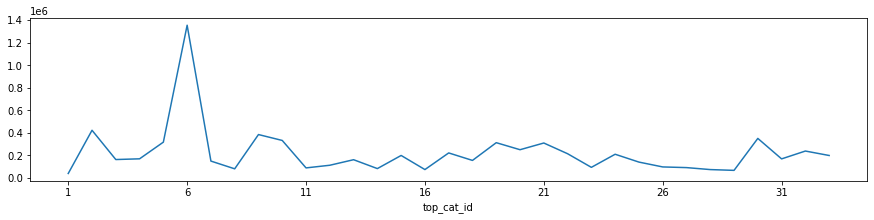

In [11]:
plt.figure(figsize=(15,3)) 
baskets.groupby(by="top_cat_id").mean().price.plot()

<AxesSubplot:xlabel='top_cat_id', ylabel='price'>

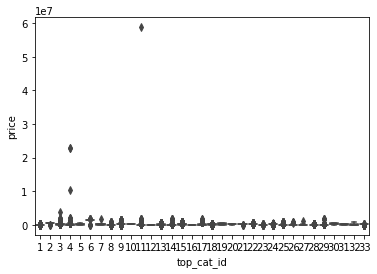

In [12]:
sns.boxplot(x='top_cat_id', y='price', data=baskets) 

<AxesSubplot:>

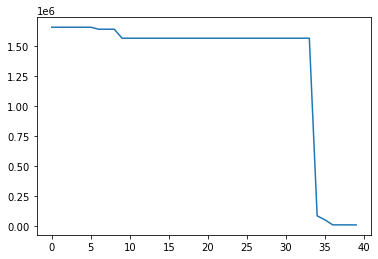

In [13]:
baskets[baskets['top_cat_id']==6].price.sort_values(ascending=False).reset_index(drop = True).plot()

In [14]:
print(1.2e+5)

120000.0


In [15]:
baskets.price.describe()

count    3.364610e+05
mean     1.378965e+05
std      1.744712e+05
min      4.375000e-02
25%      4.600000e+04
50%      1.070000e+05
75%      1.845000e+05
max      5.875000e+07
Name: price, dtype: float64

In [16]:
pd.options.display.max_rows = 100
from pprint import pprint
pprint(baskets.price.sort_values(ascending=False).reset_index(drop=True).head(100),compact=True)

0     58750000.0
1     23010000.0
2     23010000.0
3     10550000.0
4      3825000.0
5      2222000.0
6      2175000.0
7      2175000.0
8      2125000.0
9      1925000.0
10     1925000.0
11     1925000.0
12     1925000.0
13     1925000.0
14     1925000.0
15     1925000.0
16     1925000.0
17     1890000.0
18     1870000.0
19     1849000.0
20     1849000.0
21     1849000.0
22     1849000.0
23     1849000.0
24     1849000.0
25     1849000.0
26     1849000.0
27     1849000.0
28     1849000.0
29     1849000.0
30     1849000.0
31     1849000.0
32     1844000.0
33     1773000.0
34     1740000.0
35     1725000.0
36     1725000.0
37     1725000.0
38     1725000.0
39     1685000.0
40     1685000.0
41     1656500.0
42     1656500.0
43     1656500.0
44     1656500.0
45     1656500.0
46     1656500.0
47     1640000.0
48     1640000.0
49     1640000.0
50     1565000.0
51     1565000.0
52     1565000.0
53     1565000.0
54     1565000.0
55     1565000.0
56     1565000.0
57     1565000.0
58     1565000

In [17]:
pd.options.display.max_rows = 100
baskets.sort_values(by = ['price'], ascending=False).loc[:,['sku_id','price']].head(10)

,sku_id,price
78536,301,58750000.0
67262,200,23010000.0
66551,200,23010000.0
310185,432,10550000.0
5392,521,3825000.0
220150,438,2222000.0
277682,340,2175000.0
278592,340,2175000.0
2417,599,2125000.0
237889,974,1925000.0


<AxesSubplot:title={'center':'sku 340'}, xlabel='date'>

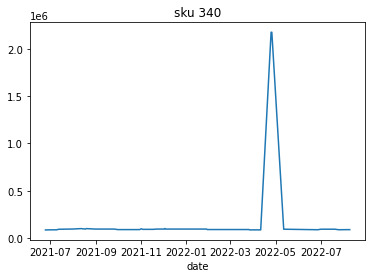

In [18]:
baskets[baskets.sku_id == 340].groupby('date').mean().price.plot(title="sku 340")

In [68]:
pd.options.display.max_rows = 100
baskets[baskets.sku_id == 340].sort_values(by='price',ascending= False).head(100)

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
278592,275340,47005,2022-04-26 13:52:47.626,1597,340,4,28,1,2175000.0,2022-04-26 13:52:47.626,2022-04-26,2022,4,26,13,1,2175000.0
277682,277828,51100,2022-04-25 21:21:43.297,608,340,4,28,1,2175000.0,2022-04-25 21:21:43.297,2022-04-25,2022,4,25,21,0,2175000.0
121064,121221,19000,2021-12-03 19:52:04.893,354,340,4,28,3,100000.0,2021-12-03 19:52:04.893,2021-12-03,2021,12,3,19,4,300000.0
11350,11435,1006,2021-08-12 11:37:13.699,305,340,4,28,1,99000.0,2021-08-12 11:37:13.699,2021-08-12,2021,8,12,11,3,99000.0
13163,13290,1211,2021-08-19 20:22:18.182,472,340,4,28,1,99000.0,2021-08-19 20:22:18.182,2021-08-19,2021,8,19,20,3,99000.0
70311,70427,9093,2021-11-01 16:08:50.574,32,340,4,28,5,97000.0,2021-11-01 16:08:50.574,2021-11-01,2021,11,1,16,0,485000.0
142767,142853,23378,2021-12-21 13:57:29.266,63,340,4,28,25,94000.0,2021-12-21 13:57:29.266,2021-12-21,2021,12,21,13,1,2350000.0
113395,113637,17266,2021-11-29 14:58:14.928,559,340,4,28,25,94000.0,2021-11-29 14:58:14.928,2021-11-29,2021,11,29,14,0,2350000.0
115434,115620,17825,2021-11-30 15:21:30.102,156,340,4,28,25,94000.0,2021-11-30 15:21:30.102,2021-11-30,2021,11,30,15,1,2350000.0
118247,118408,18469,2021-12-02 12:39:15.964,754,340,4,28,25,94000.0,2021-12-02 12:39:15.964,2021-12-02,2021,12,2,12,3,2350000.0


<AxesSubplot:title={'center':'top_cat_id 6'}, xlabel='date'>

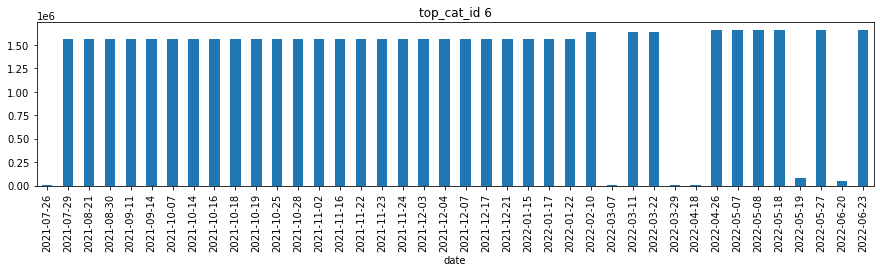

In [19]:
plt.figure(figsize=(15,3)) 
baskets[baskets.top_cat_id == 6].groupby('date').mean().price.plot(title="top_cat_id 6",kind='bar')

<AxesSubplot:title={'center':'top_cat_id 6'}, xlabel='date'>

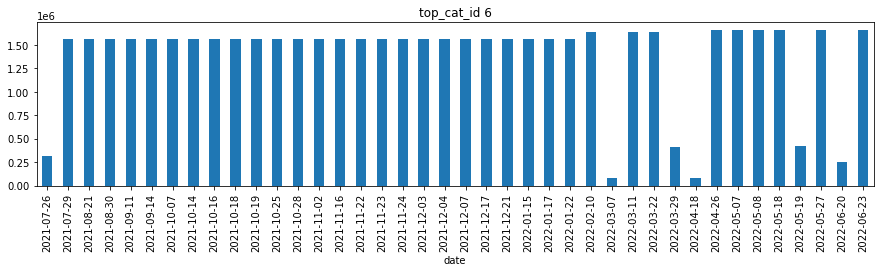

In [20]:
plt.figure(figsize=(15,3)) 
baskets[baskets.top_cat_id == 6].groupby('date').sum().spent.plot(title="top_cat_id 6",kind='bar')

In [21]:
baskets[baskets.top_cat_id == 6.0].sort_values(by="merchant_id")

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
259394,259603,47527,2022-03-29 09:26:08.555,33,822,6,33,50,8300.0,2022-03-29 09:26:08.555,2022-03-29,2022,3,29,9,1,415000.0
7304,7367,621,2021-07-26 13:05:45.662,35,822,6,33,40,7950.0,2021-07-26 13:05:45.662,2021-07-26,2021,7,26,13,0,318000.0
295747,295853,54049,2022-05-27 17:34:50.006,122,822,6,33,1,1656500.0,2022-05-27 17:34:50.006,2022-05-27,2022,5,27,17,4,1656500.0
72515,72669,9649,2021-11-02 17:58:27.709,148,822,6,33,1,1565000.0,2021-11-02 17:58:27.709,2021-11-02,2021,11,2,17,1,1565000.0
59434,59428,7554,2021-10-25 15:10:53.414,148,822,6,33,1,1565000.0,2021-10-25 15:10:53.414,2021-10-25,2021,10,25,15,0,1565000.0
205859,206093,36999,2022-02-10 11:35:19.843,261,822,6,33,1,1640000.0,2022-02-10 11:35:19.843,2022-02-10,2022,2,10,11,3,1640000.0
173336,173450,29993,2022-01-17 13:46:09.700,375,822,6,33,1,1565000.0,2022-01-17 13:46:09.700,2022-01-17,2022,1,17,13,0,1565000.0
103623,103790,15474,2021-11-23 09:31:53.009,375,822,6,33,1,1565000.0,2021-11-23 09:31:53.009,2021-11-23,2021,11,23,9,1,1565000.0
103027,103178,15370,2021-11-22 15:52:03.238,375,822,6,33,1,1565000.0,2021-11-22 15:52:03.238,2021-11-22,2021,11,22,15,0,1565000.0
93710,93844,13293,2021-11-16 09:47:12.814,375,822,6,33,1,1565000.0,2021-11-16 09:47:12.814,2021-11-16,2021,11,16,9,1,1565000.0


In [22]:
baskets10.sort_values(by = ['price'], ascending=True).loc[:,['sku_id','price']]

,sku_id,price
0,341,0.0
807,810,0.0
808,811,0.0
809,607,0.0
810,1229,0.0
...,...,...
22218,1463,1925000.0
29189,1463,1925000.0
29188,1461,1925000.0
26619,1463,1925000.0


In [23]:
baskets250.price.sort_values(ascending=False).head(10)

2130      3825000.0
134738    2175000.0
763       2125000.0
142500    1925000.0
142499    1925000.0
168446    1925000.0
112471    1925000.0
109325    1925000.0
164746    1925000.0
164745    1925000.0
Name: price, dtype: float64

In [24]:
baskets.price.sort_values(ascending=False).head()

78536     58750000.0
67262     23010000.0
66551     23010000.0
310185    10550000.0
5392       3825000.0
Name: price, dtype: float64

In [25]:
baskets[baskets['price']==58750000.0]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
78536,78641,10750,2021-11-06 09:53:53.181,1103,301,11,27,1,58750000.0,2021-11-06 09:53:53.181,2021-11-06,2021,11,6,9,5,58750000.0


In [26]:
baskets10[baskets10['price']==2175000.0]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
25568,285542,47838,2022-04-26 13:52:47.626,2173,774,4,31,1,2175000.0,2022-04-26 13:52:47.626,2022-04-26,2022,4,26,13,1,2175000.0


In [27]:
baskets[baskets['sku_id'] == 301]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
917,914,83,2021-06-17 10:27:52.447,302,301,11,27,50,23250.0,2021-06-17 10:27:52.447,2021-06-17,2021,6,17,10,3,1162500.0
1451,1784,129,2021-06-24 12:43:03.065,22,301,11,27,50,22000.0,2021-06-24 12:43:03.065,2021-06-24,2021,6,24,12,3,1100000.0
1515,1514,135,2021-06-24 23:31:59.247,114,301,11,27,10,22000.0,2021-06-24 23:31:59.247,2021-06-24,2021,6,24,23,3,220000.0
1529,1528,136,2021-06-24 23:58:49.239,114,301,11,27,50,24500.0,2021-06-24 23:58:49.239,2021-06-24,2021,6,24,23,3,1225000.0
1571,1570,137,2021-06-25 00:01:29.306,109,301,11,27,50,24500.0,2021-06-25 00:01:29.306,2021-06-25,2021,6,25,0,4,1225000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335546,335629,61825,2022-08-13 23:23:58.111,665,301,11,27,10,25500.0,2022-08-13 23:23:58.111,2022-08-13,2022,8,13,23,5,255000.0
336143,336225,62017,2022-08-15 14:37:01.641,146,301,11,27,50,25500.0,2022-08-15 14:37:01.641,2022-08-15,2022,8,15,14,0,1275000.0
336211,336249,61920,2022-08-15 15:15:51.713,441,301,11,27,150,25500.0,2022-08-15 15:15:51.713,2022-08-15,2022,8,15,15,0,3825000.0
336255,336310,61998,2022-08-15 16:51:02.716,1770,301,11,27,50,25500.0,2022-08-15 16:51:02.716,2022-08-15,2022,8,15,16,0,1275000.0


In [28]:
baskets10[baskets10['sku_id'] == 340]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent
72,1289,298,2021-05-24 11:40:06.796,223,340,12,1,5,0.0,2021-05-24 11:40:06.796,2021-05-24,2021,5,24,11,0,0.0
79,2013,344,2021-06-15 09:57:31.177,349,340,12,1,5,18500.0,2021-06-15 09:57:31.177,2021-06-15,2021,6,15,9,1,92500.0


In [29]:
baskets.groupby(['sku_id']).count().order_id.sort_values(ascending=False).reset_index().head(100)

,sku_id,order_id
0,327,7500
1,522,6919
2,390,6409
3,438,5589
4,523,4804
5,263,4548
6,185,4463
7,521,4462
8,276,3718
9,184,3480


In [30]:
from pprint import pprint
pprint(list(skus[skus["sku_id"] == 438].date), compact = True)

[datetime.date(2021, 4, 9), datetime.date(2021, 4, 15),
 datetime.date(2021, 4, 16), datetime.date(2021, 4, 17),
 datetime.date(2021, 4, 19), datetime.date(2021, 4, 20),
 datetime.date(2021, 4, 22), datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 3), datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6), datetime.date(2021, 5, 8),
 datetime.date(2021, 5, 9), datetime.date(2021, 5, 10),
 datetime.date(2021, 5, 11), datetime.date(2021, 5, 17),
 datetime.date(2021, 5, 18), datetime.date(2021, 5, 19),
 datetime.date(2021, 5, 20), datetime.date(2021, 5, 21),
 datetime.date(2021, 5, 22), datetime.date(2021, 5, 24),
 datetime.date(2021, 5, 26), datetime.date(2021, 5, 27),
 datetime.date(2021, 5, 31), datetime.date(2021, 6, 2),
 datetime.date(2021, 6, 3), datetime.date(2021, 6, 4),
 datetime.date(2021, 6, 7), datetime.date(2021, 6, 8),
 datetime.date(2021, 6, 9), datetime.date(2021, 6, 10),
 datetime.date(2021, 6, 11), datetime.date(2021, 6, 14),
 datetime.date(2021, 6, 15), datetime.date(

<AxesSubplot:xlabel='date'>

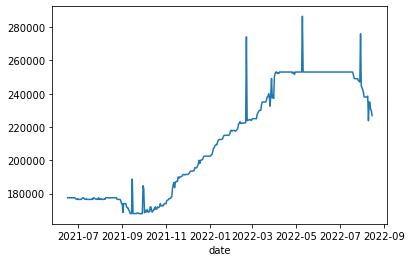

In [31]:
baskets[baskets.sku_id == 438].groupby('date').mean().price.plot()

<AxesSubplot:xlabel='date'>

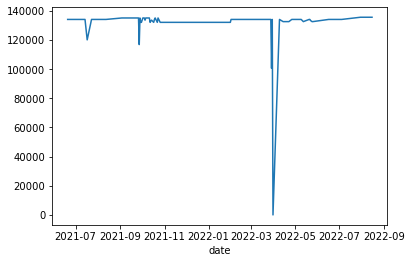

In [32]:
baskets[baskets.sku_id == 277].groupby('date').mean().price.plot()

<AxesSubplot:>

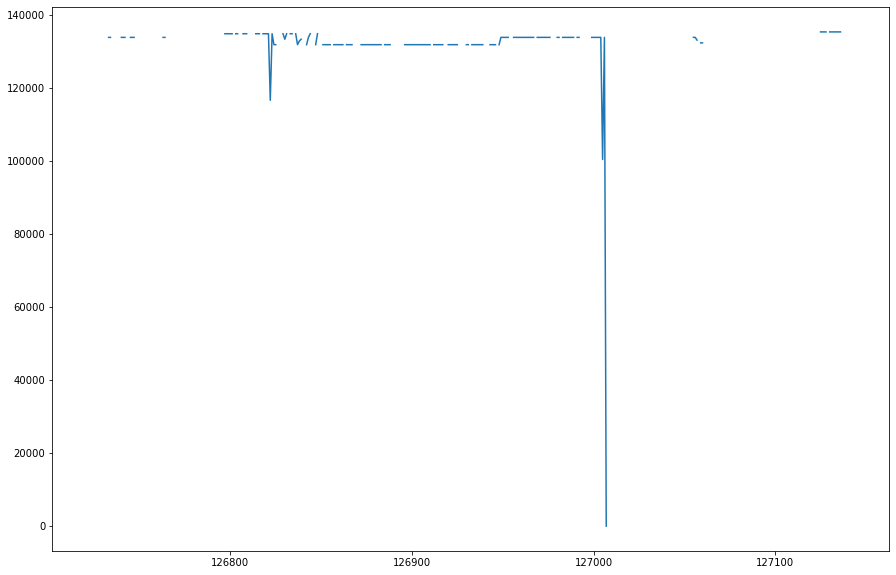

In [33]:
plt.figure(figsize=(15,10)) 
skus[skus["sku_id"] == 277].avg_price_by_day.plot()

<AxesSubplot:>

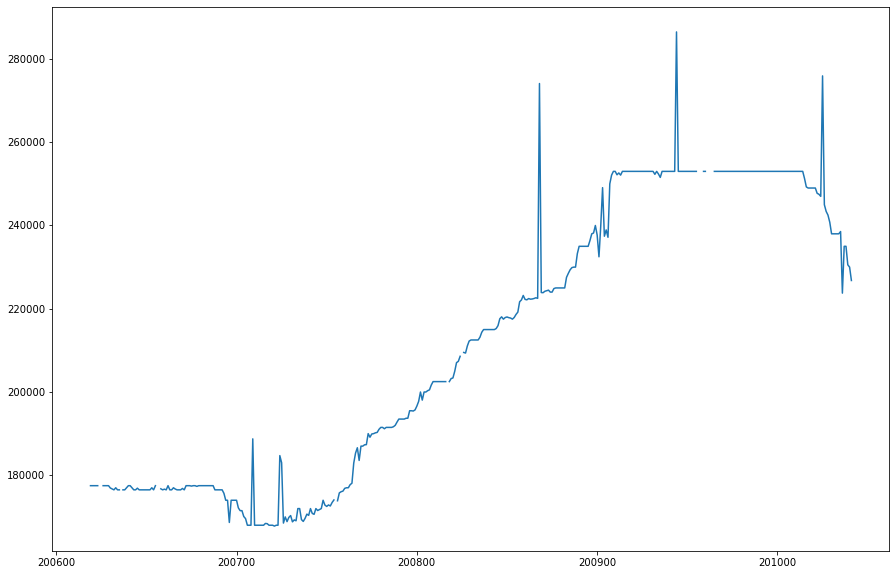

In [34]:
plt.figure(figsize=(15,10)) 
skus[skus["sku_id"] == 438].avg_price_by_day.plot()

In [35]:
skus10.groupby(['sku_id']).count().date.sort_values()

sku_id
5       396
1516    396
1515    396
1514    396
1513    396
       ... 
944     396
943     396
942     396
952     396
2383    396
Name: date, Length: 1348, dtype: int64

<Figure size 1080x720 with 0 Axes>

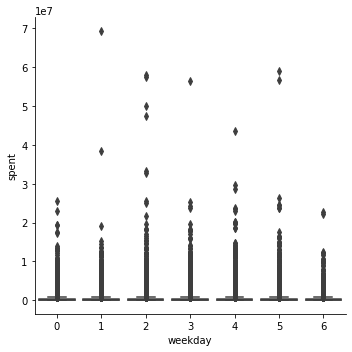

In [36]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="weekday", y = "spent",data=baskets250, palette="Set1",kind="box")

<Figure size 1080x2160 with 0 Axes>

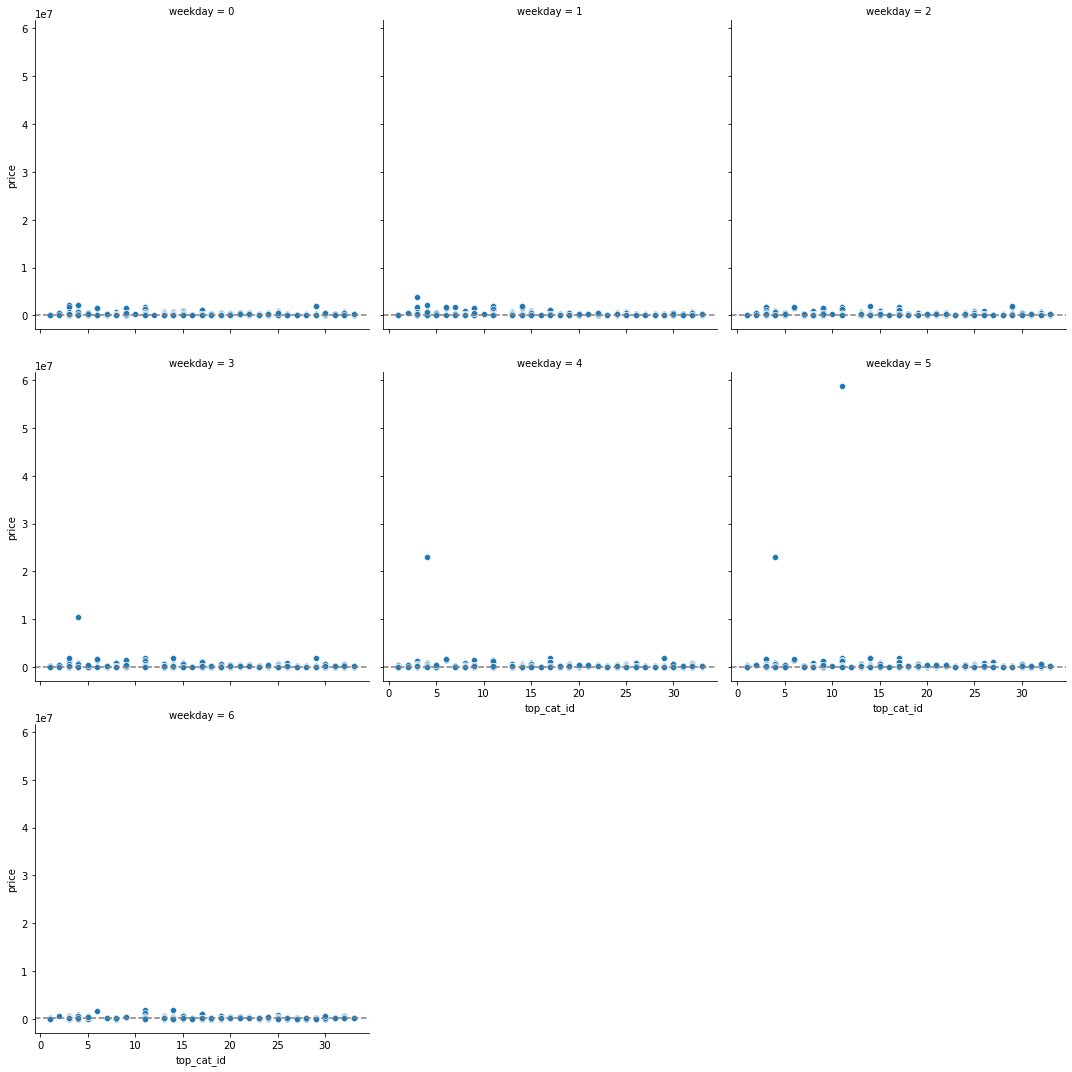

In [80]:
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets["price"].median())

<Figure size 1080x2160 with 0 Axes>

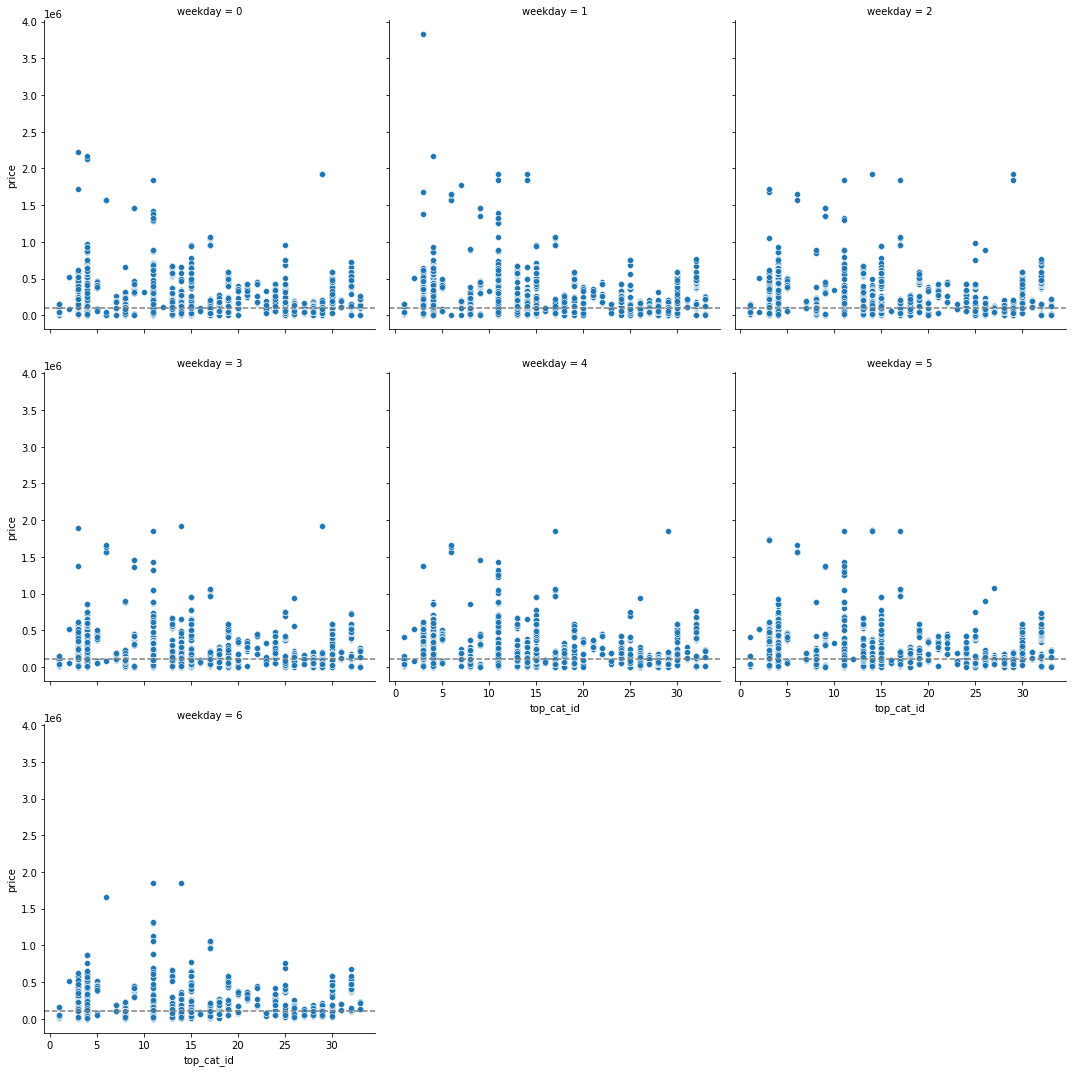

In [90]:
baskets1 = baskets.drop(baskets[baskets['price']> 10000000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets1["price"].median())


<Figure size 1080x2160 with 0 Axes>

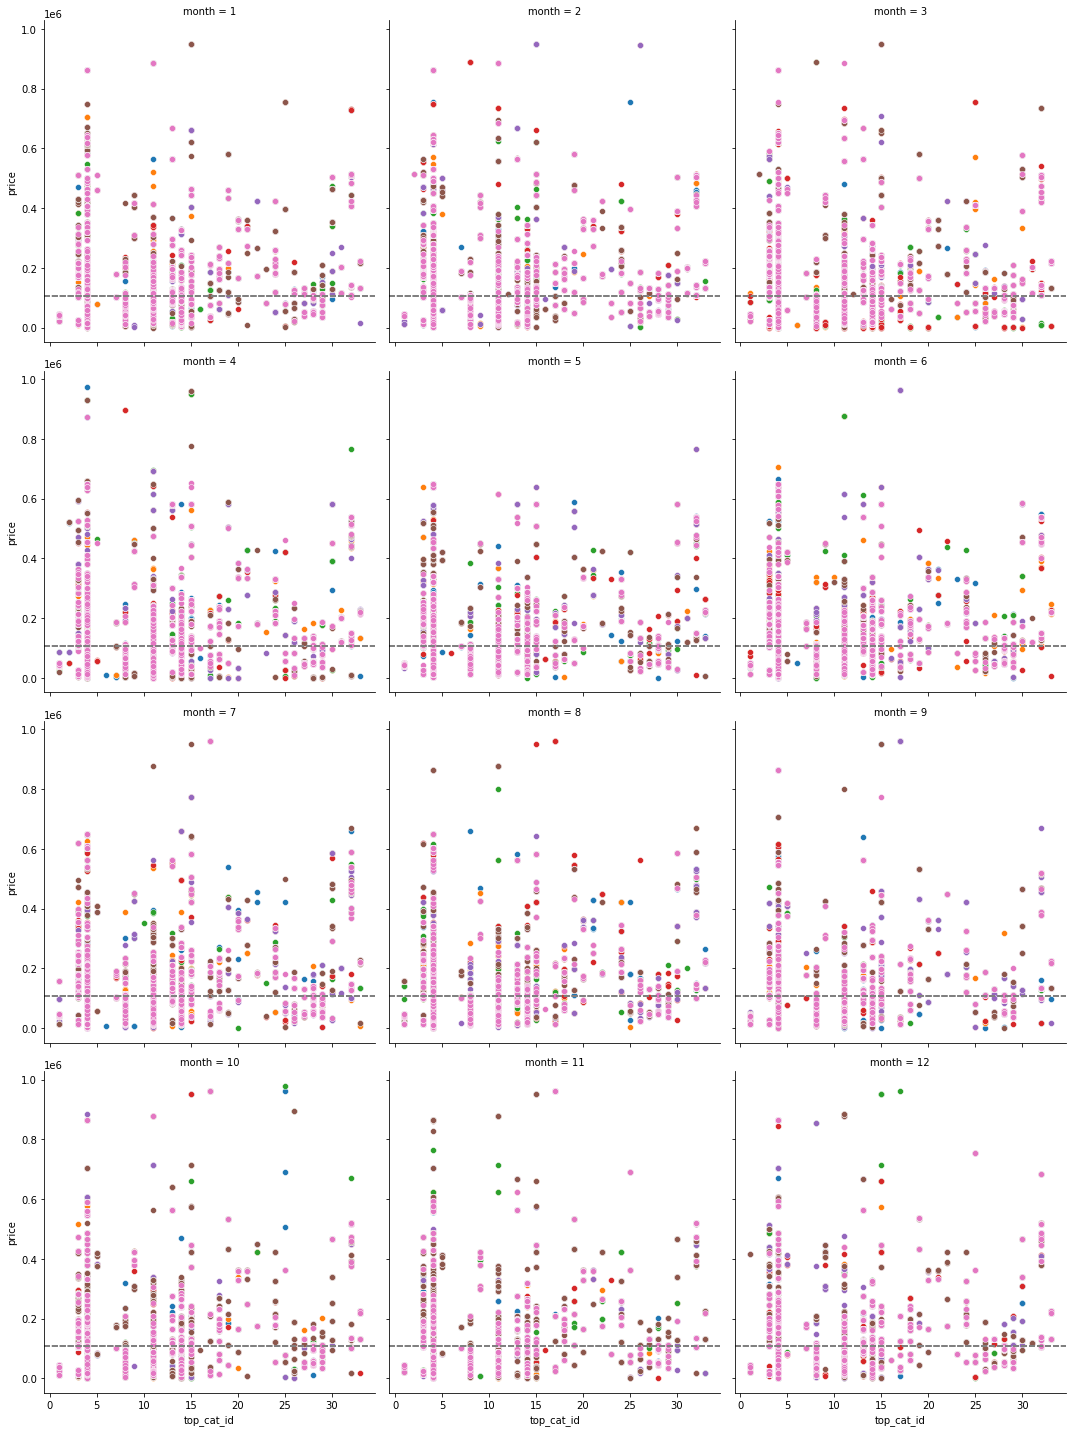

In [102]:
baskets1 = baskets.drop(baskets[baskets['price']> 1000000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="month", hue='weekday', height=5, col_wrap=3)

g.map_dataframe(sns.scatterplot, x="top_cat_id",y="price")
g.refline(y=baskets1["price"].median())

<Figure size 1080x2160 with 0 Axes>

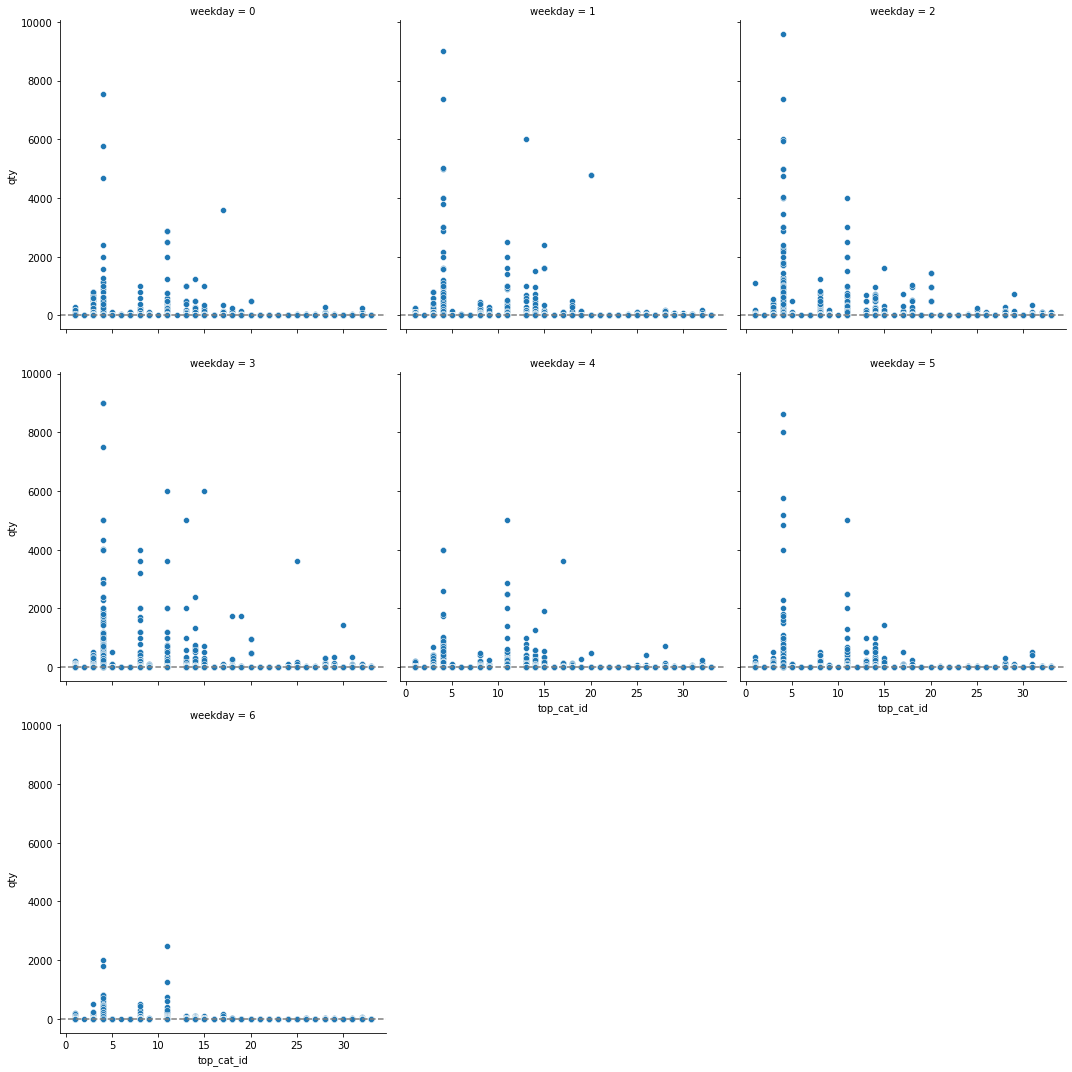

In [103]:
baskets1 = baskets.drop(baskets[baskets['qty']> 10000].index,axis=0)
plt.figure(figsize=(15,30)) 
g = sns.FacetGrid(baskets1, col="weekday", height=5, col_wrap=3)
g.map_dataframe(sns.scatterplot, x="top_cat_id",y="qty")
g.refline(y=baskets1["qty"].median())

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

<AxesSubplot:xlabel='avg_spent_per_order', ylabel='Density'>

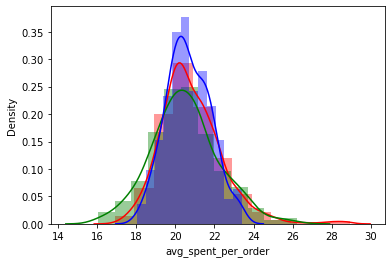

In [40]:
from turtle import color


sns.distplot(merchants.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='red')
sns.distplot(merchants10.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='green')
sns.distplot(merchants250.avg_spent_per_order.apply(lambda x: math.log(x,2)),bins=12,color='blue')


In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score



def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df




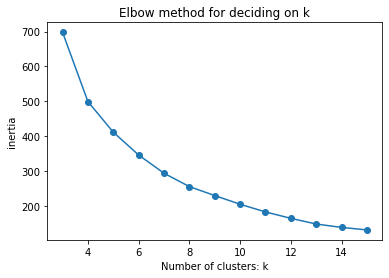

In [46]:
df = merchants10
colnames = merchants10.columns[2:]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df, colnames,clusters_range)

#kmeans.cluster_centers_

In [47]:
df = merchants10
colnames = merchants10.columns[2:]
k = 6
merchants10_kmeans = run_kmeans(df, colnames,k)
merchants10_kmeans.groupby("cluster").size()


cluster
0     55
1    151
2      5
3     10
4     14
5     82
dtype: int64

In [48]:
df = merchants10
colnames = merchants10.columns[2:]
k = 5
merchants10_kmeans = run_kmeans(df, colnames,k)
merchants10_kmeans.groupby("cluster").size()

cluster
0     82
1      5
2    151
3     22
4     57
dtype: int64

In [49]:
df = merchants
colnames = merchants.columns[2:]
k = 5
merchants_kmeans = run_kmeans(df, colnames,k)
merchants_kmeans.groupby("cluster").size()

cluster
0     205
1    1193
2       1
3     725
4      14
dtype: int64

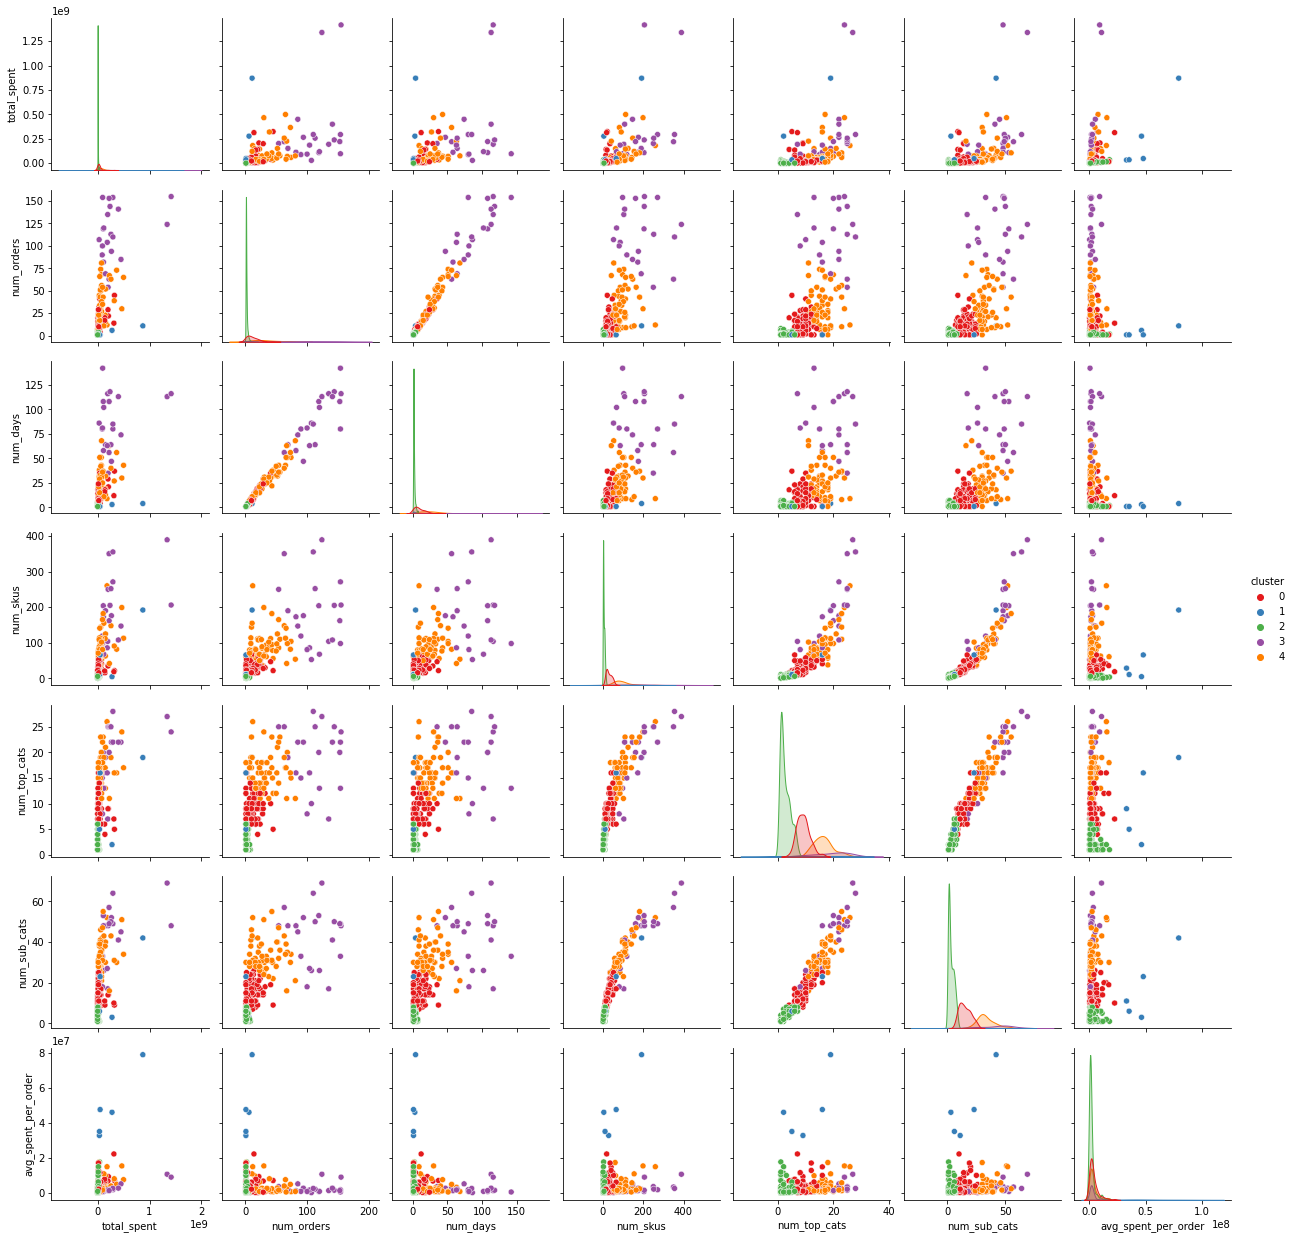

In [51]:
sns.pairplot(data=merchants10_kmeans, hue="cluster", palette="Set1")


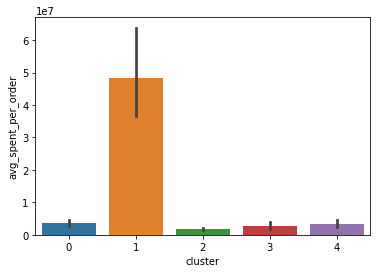

In [52]:
ax = sns.barplot(x="cluster", y="avg_spent_per_order", data=merchants10_kmeans)

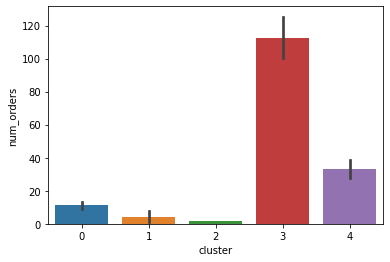

In [53]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchants10_kmeans)

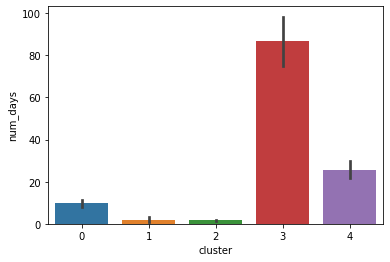

In [54]:
ax = sns.barplot(x="cluster", y="num_days", data=merchants10_kmeans)

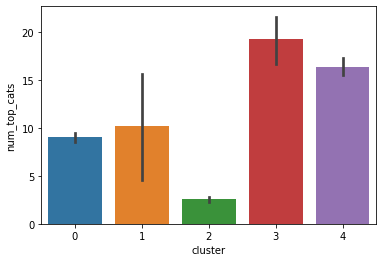

In [55]:
ax = sns.barplot(x="cluster", y="num_top_cats", data=merchants10_kmeans)

In [56]:
merchants10_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   merchant_id          317 non-null    category
 1   total_spent          317 non-null    float64 
 2   num_orders           317 non-null    int64   
 3   num_days             317 non-null    int64   
 4   num_skus             317 non-null    int64   
 5   num_top_cats         317 non-null    int64   
 6   num_sub_cats         317 non-null    int64   
 7   avg_spent_per_order  317 non-null    float64 
 8   cluster              317 non-null    int32   
dtypes: category(1), float64(2), int32(1), int64(5)
memory usage: 29.9 KB


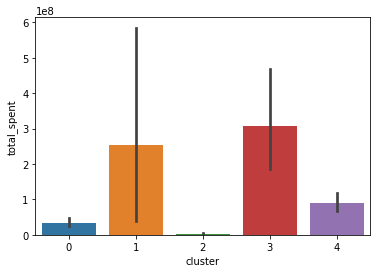

In [57]:
ax = sns.barplot(x="cluster", y="total_spent", data=merchants10_kmeans)

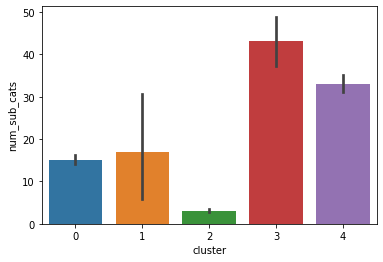

In [58]:
ax = sns.barplot(x="cluster", y="num_sub_cats", data=merchants10_kmeans)

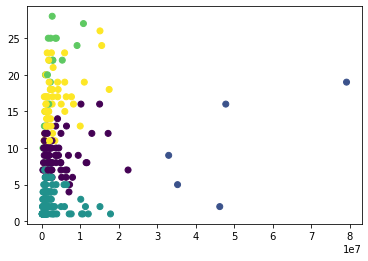

In [59]:

plt.scatter(merchants10["avg_spent_per_order"], merchants10["num_top_cats"],c=merchants10.cluster)
plt.show()

In [ ]:
#Counting the frequency
freq = baskets['merchant_id'].value_counts()
print(freq)

In [ ]:
frequency_df = baskets.groupby(
    by=['merchant_id'], as_index=False)['date'].count()
frequency_df.columns = ['merchant_id', 'Frequency']
frequency_df.head()

In [ ]:
merchants.avg_spent_per_order.sort_values(ascending=False).reset_index(drop=True).head(33)

In [ ]:
merchants.num_days.plot()

In [ ]:
merchants.total_spent.plot()

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(merchants_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
ax = sns.barplot(x="cluster", y="avg_spent_per_order", data=merchants_data)

### cluster 3 looks like containing merchants who have high average spending per orders.

In [ ]:
ax = sns.barplot(x="cluster", y="num_orders", data=merchants_data)

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_top_cats",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_sub_cats",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="num_days", y = "num_orders",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

In [ ]:
plt.figure(figsize=(15,10)) 
ax = sns.catplot(x="avg_spent_per_order", y = "num_days",data=merchants_data, hue="cluster", palette="Set1",ci="sd")

### cluster 4 consists of the merchants that have high number of days, 4 of them all above 100?
